# 루브릭
1. 인물모드 사진을 성공적으로 제작하였다.

아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.

인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.

추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

# 프로젝트: 인물 모드의 문제점 찾기
***
목차

Step 1. 인물모드 직접 해 보기

Step 2. 사진에서 문제점 찾기

Step 3. 해결 방법을 제안해 보기

회고

# Step 1. 인물모드 직접 해 보기
- 아웃포커싱 효과를 간단히 함수로 정리 하자. 3장 이상의 인물 모드 사진을 만들자.(내사진, 고양이, 바이크)
- 주인공이 아닌 고양이에 대한 아웃포커싱 사진을 만들어 보자.(주인공, 고양이 가 함께 있는 사진 필요)
- blur 가 아닌 배경을 다른 이미지로 교체하는 크로마키 배경 합성하자


In [4]:
# 아웃포커싱 효과를 간단히 함수로 정리 하자
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [5]:
def get_img_orig(img_path):
    # 이미지 읽기
    img_orig = cv2.imread(img_path)
    print(img_orig.shape)
#     plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
#     plt.title('Original Image')
#     plt.show()
    return img_orig

In [6]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
# 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [7]:
def get_segmentation(img_path, img_orig_shape):
    # 모델에 이미지 입력
    segvalues, output = model.segmentAsPascalvoc(img_path) #PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미
    # 시계방향으로 90도 회전
    if img_orig_shape != output.shape:
        output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)
    plt.imshow(output)
    plt.title('Segmented Image')
    plt.show()
    
    # PASCAL VOC 데이터의 라벨 종류
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    for class_id in segvalues['class_ids']:
        print(class_id, ':', LABEL_NAMES[class_id])
    return output
    #print(segvalues)

In [8]:
def get_colormap(output):
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    colormap[:20]
    
    labels  = input('SELECT LABEL TO BLUR (serate with space to select multiple object, ex)"8 15" : ')
    labels = labels.split()
    labels = list(map(int,labels))
    #print(output.shape)
    seg_map = np.zeros(output.shape)
    seg_map = seg_map[:, :, 0]
    
    for label in labels: # 복수의 라벨을 선택 가능하게 코드 수정
        seg_color = list(colormap[label])
        seg_color = (seg_color[2], seg_color[1], seg_color[0])
        seg_map_temp = np.all(output == seg_color, axis=-1)
        #print(seg_map_temp.shape)
        seg_map = np.any([seg_map_temp, seg_map], axis= 0)
        
    #seg_color = list(colormap[label])#라벨의 컬러맵
    #seg_color = (seg_color[2], seg_color[1], seg_color[0]) # 색상값 순서를 바꾼다.
    # seg_color로만 이루어진 마스크
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    # 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었다.
    
    #seg_map = np.all(output == seg_colors, axis=-1)
    print(seg_map.shape)
#     plt.imshow(seg_map, cmap='gray')
#     plt.title('Gray_Segmented Image')
#     plt.show()
    return seg_map

In [9]:
def get_img_mask(img_orig, seg_map):
    # 원래 이미지와 겹쳐서 확인
    img_show = img_orig.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

#     plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
#     plt.title('Masked Image')
#     plt.show()
    return img_show, img_mask

In [10]:
def get_blur_img(img_orig, img_mask, blur_kernel_size = (50,50)):
    img_orig_blur = cv2.blur(img_orig, blur_kernel_size )
#     plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
#     plt.title('Blurred Image')
#     plt.show()
    # 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
#     plt.title('Segmented Blurred Image')
#     plt.show()
    return img_orig_blur, img_bg_blur, img_mask_color

In [11]:
def get_concatenated_img(img_orig, img_bg_blur, img_mask_color):
    # 원본과 사람 영상 합치기
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#     plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
#     plt.title('Concatenated Image')
#     plt.show()
    return img_concat

In [12]:
def img_sub_plot(imgs, imgs_title):
    fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
    rows = 2
    cols = 4
    i = 1
    for img in imgs:
        ax = fig.add_subplot(rows, cols, i)
        if imgs_title[i-1] == 'Segmented Image': # 예외1
            plt.imshow(img)
        elif imgs_title[i-1] == 'Gray_Segmented Image': # 예외 2
            plt.imshow(img, cmap='gray')
        else:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(imgs_title[i-1])
        i += 1
        
    plt.show()

In [13]:
# 인물 사진 모드 메인 함수

def get_portrait_mode(img_path):
    # 이미지 읽기
    img_orig = get_img_orig(img_path)
    
    # 모델에 이미지 입력
    output = get_segmentation(img_path, img_orig.shape)
    
    seg_map = get_colormap(output)
    
    img_show, img_mask = get_img_mask(img_orig, seg_map)
    
    img_orig_blur, img_bg_blur, img_mask_color = get_blur_img(img_orig, img_mask, blur_kernel_size = (50,50))
    
    img_concat = get_concatenated_img(img_orig, img_bg_blur, img_mask_color)
    
    imgs = (img_orig, output, seg_map, img_show, img_orig_blur , img_bg_blur, img_concat)
    imgs_title = ('Original Image', 'Segmented Image', 'Gray_Segmented Image', 'Masked Image', 'Blurred Image',
                  'Segmented Blurred Image', 'Concatenated Image')
    img_sub_plot(imgs, imgs_title)

(4032, 3024, 3)
0 : background
15 : person
SELECT LABEL TO BLUR : 15
[192, 128, 128]
(4032, 3024)


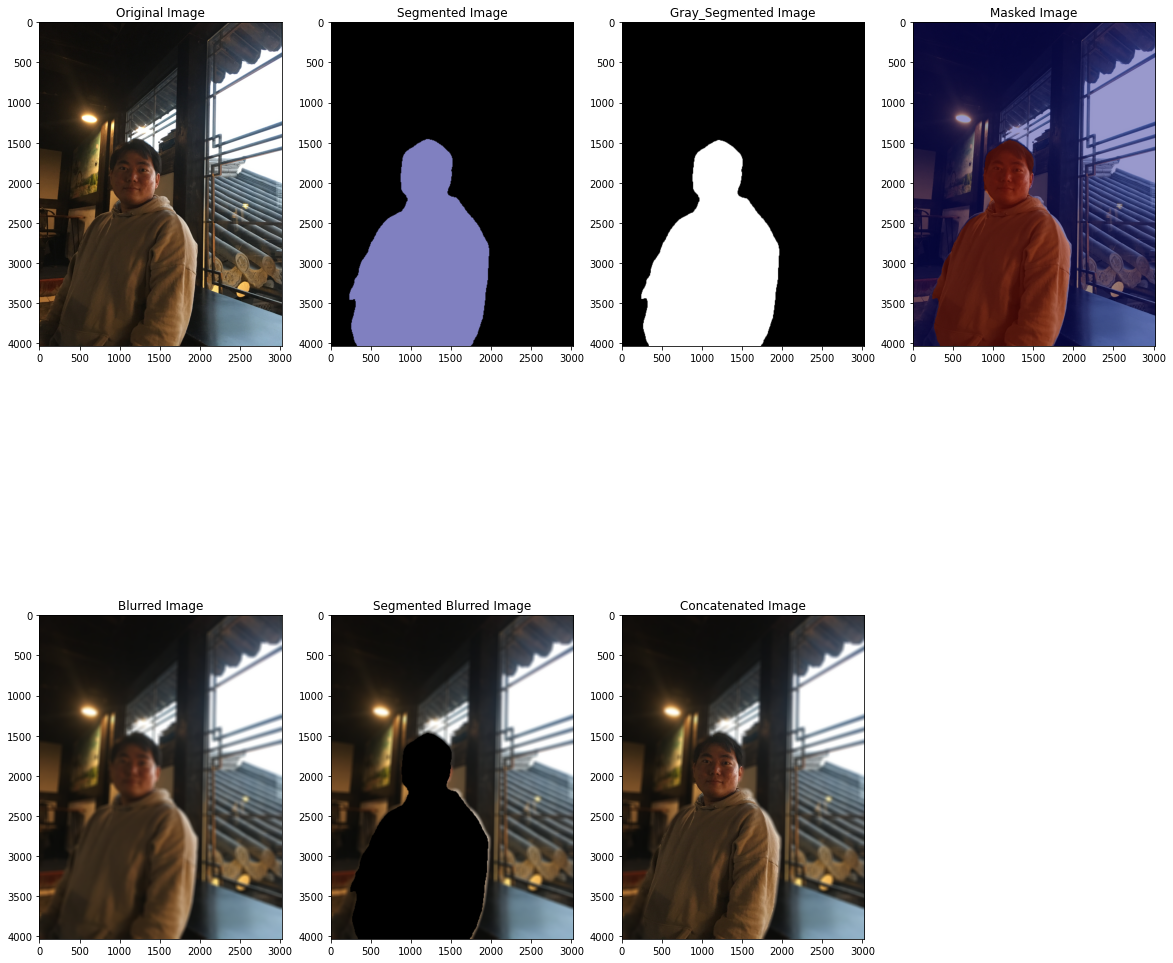

In [130]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/허남철.jpg' 
get_portrait_mode(img_path)

(750, 524, 3)
0 : background
8 : cat
SELECT LABEL TO BLUR : 8
[64, 0, 0]
(750, 524)


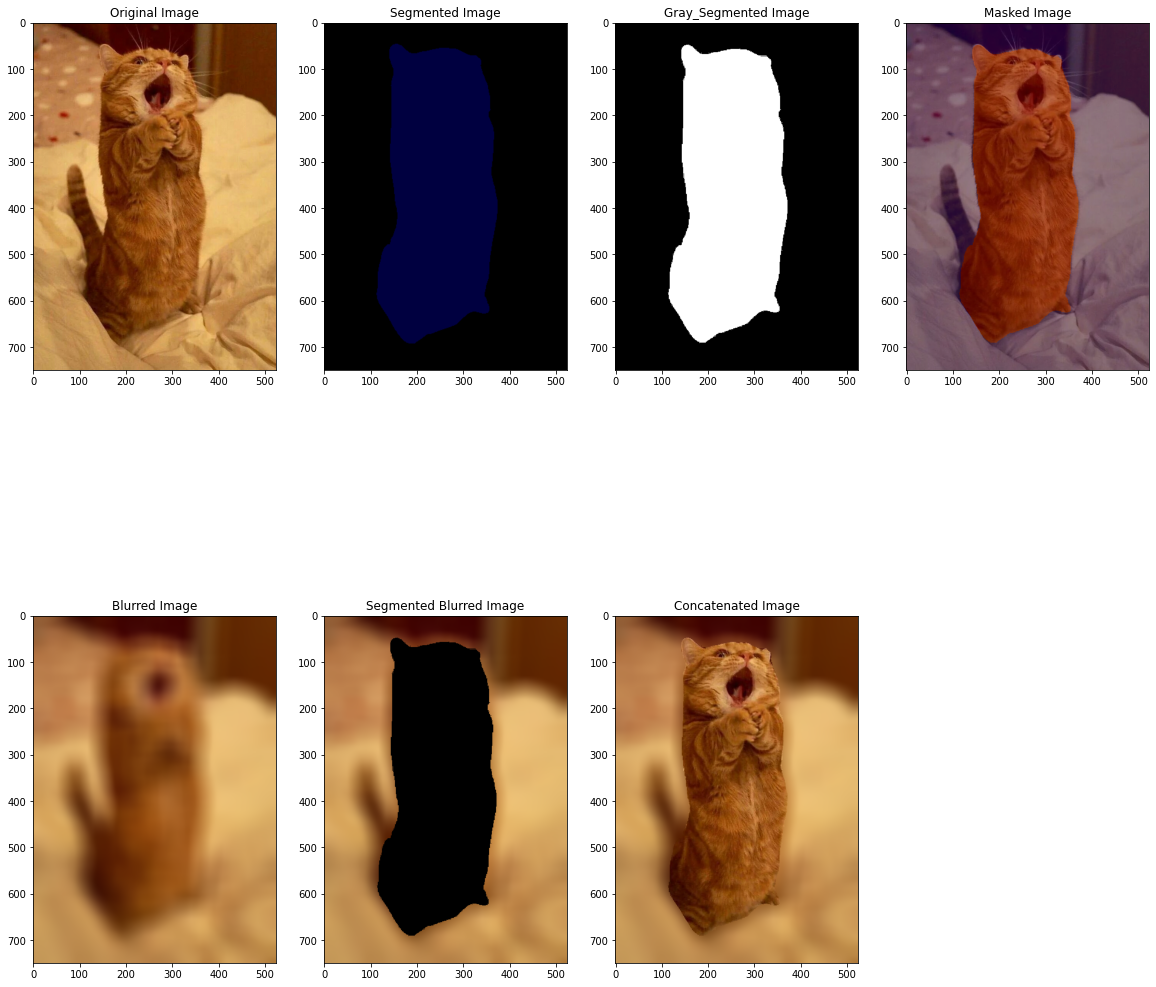

In [131]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.PNG' 
get_portrait_mode(img_path)

(432, 650, 3)
0 : background
14 : motorbike
15 : person
SELECT LABEL TO BLUR : 14
[64, 128, 128]
(432, 650)


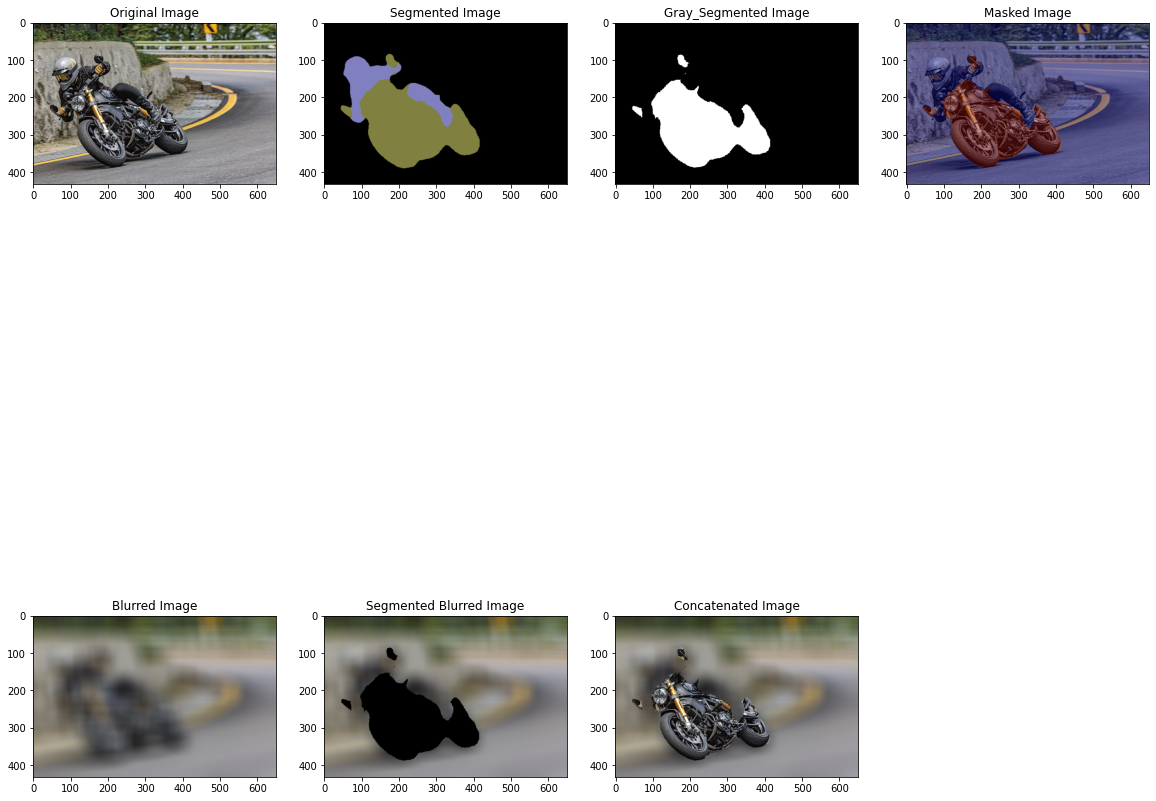

In [132]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bike.jpg' 
get_portrait_mode(img_path)

# 크로마키 배경 합성하기

- 상기 작성한 메인 함수에 배경이미지를 불러오고
- 중심에서 원본이미지 크기에 맞게 자르고
- 블러이미지 대신 배경이미지가 들어가도록 수정하였다.

In [200]:
def get_chromakey_mode(img_path, backgrd_img_path):
    # 이미지 읽기
    img_orig = get_img_orig(img_path)
    backgrd_img = get_img_orig(backgrd_img_path)
    plt.imshow(cv2.cvtColor(backgrd_img, cv2.COLOR_BGR2RGB))
    plt.title('Background Image')
    plt.show()
    # 중심에 놓기 위한 좌표 계산
    height1, width1 = img_orig.shape[:2]
    height2, width2 = backgrd_img.shape[:2]
    x = (width2 - width1)//2
    y = (height2 - height1)//2
    w = x + width1
    h = y + height1

    # x y w h 로 자르기
    print(x,y, w, h)
    backgrd_img = backgrd_img[ y : h,x : w]
    print('조절된 배경크기',backgrd_img.shape)
    
    # 모델에 이미지 입력
    output = get_segmentation(img_path, img_orig.shape)
    
    seg_map = get_colormap(output)
    
    img_show, img_mask = get_img_mask(img_orig, seg_map)
    
    img_orig_blur, img_bg_blur, img_mask_color = get_blur_img(img_orig, img_mask, blur_kernel_size = (50,50))
    
    img_concat = get_concatenated_img(img_orig, backgrd_img, img_mask_color)
    
    imgs = (img_orig, output, seg_map, img_show,  img_concat)
    imgs_title = ('Original Image', 'Segmented Image', 'Gray_Segmented Image', 'Masked Image','Concatenated Image')
    img_sub_plot(imgs, imgs_title)

(4032, 3024, 3)
(1080, 1920, 3)


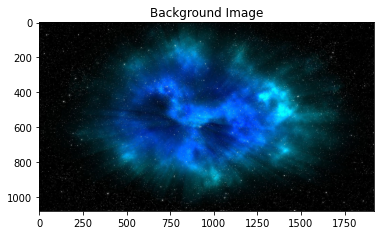

-552 -1476 2472 2556
조절된 배경크기 (1080, 552, 3)


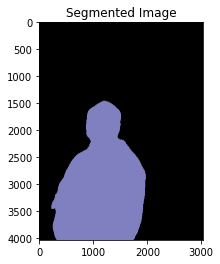

0 : background
15 : person
SELECT LABEL TO BLUR (serate with space to select multiple object, ex)"8 15" : 15
(4032, 3024)


ValueError: operands could not be broadcast together with shapes (4032,3024,3) (4032,3024,3) (1080,552,3) 

In [205]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/허남철.jpg'
backgrd_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/space.jpg'
get_chromakey_mode(img_path, backgrd_img_path)

(750, 524, 3)
(1080, 1920, 3)


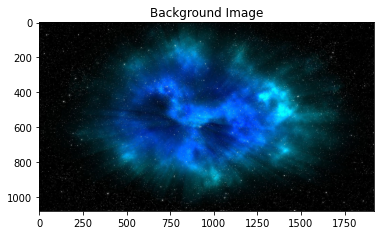

698 165 1222 915
조절된 배경크기 (750, 524, 3)


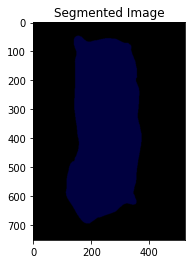

0 : background
8 : cat
SELECT LABEL TO BLUR (serate with space to select multiple object, ex)"8 15" : 8
(750, 524)


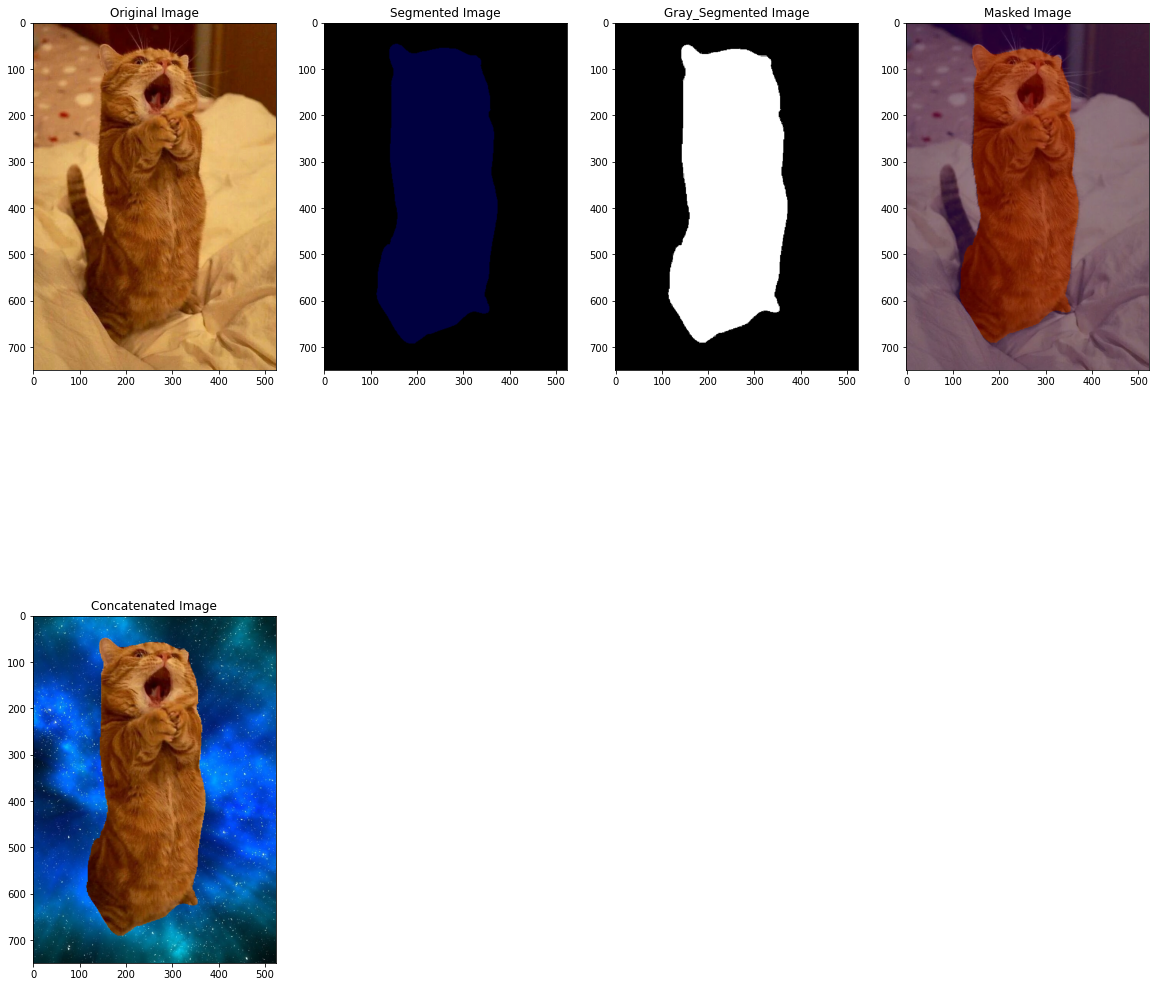

In [203]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.PNG'
backgrd_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/space.jpg'
get_chromakey_mode(img_path, backgrd_img_path)

(432, 650, 3)
(1080, 1920, 3)


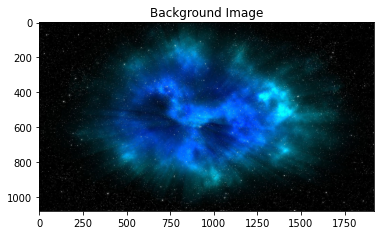

635 324 1285 756
조절된 배경크기 (432, 650, 3)


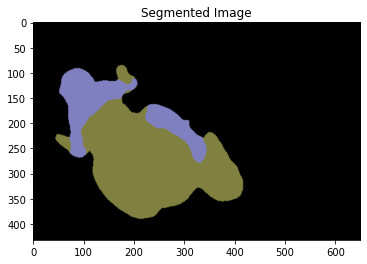

0 : background
14 : motorbike
15 : person
SELECT LABEL TO BLUR (serate with space to select multiple object, ex)"8 15" : 14 15
(432, 650)


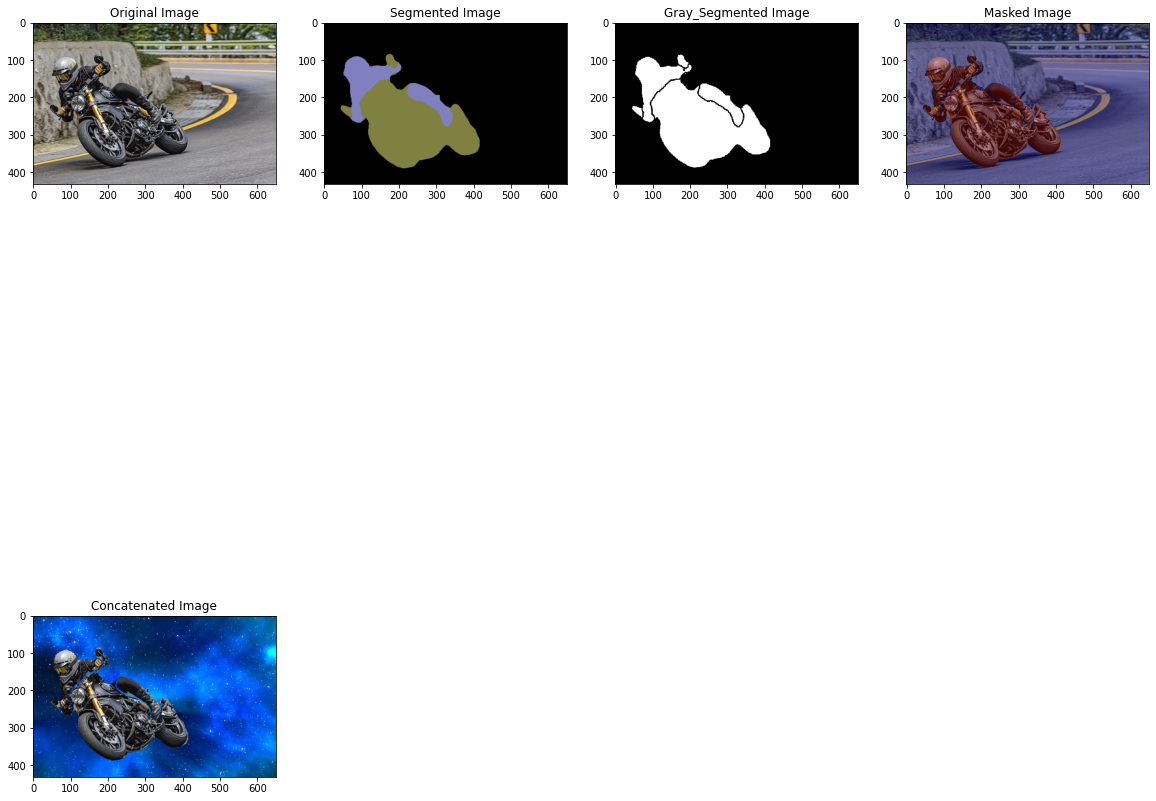

In [201]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bike.jpg'
backgrd_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/space.jpg'
get_chromakey_mode(img_path, backgrd_img_path)

# Step 2. 사진에서 문제점 찾기
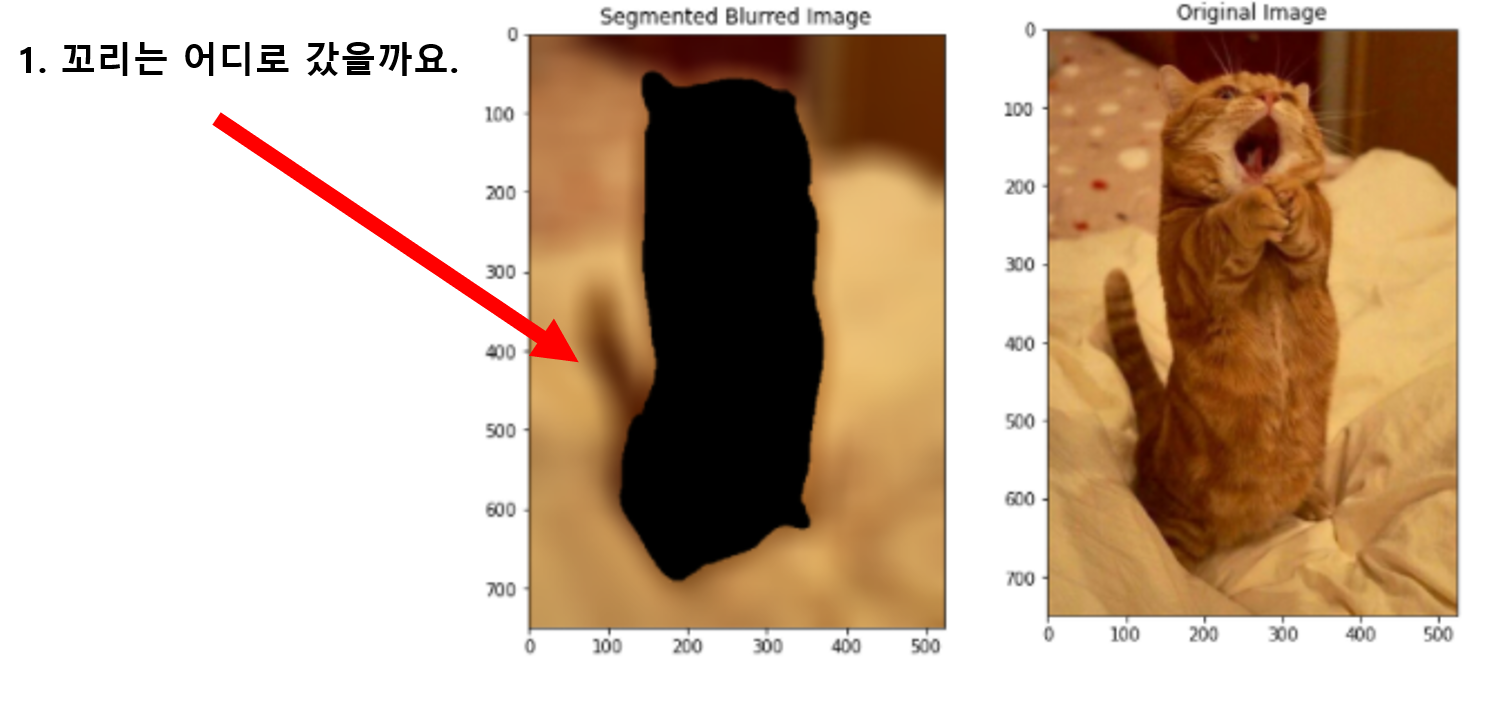

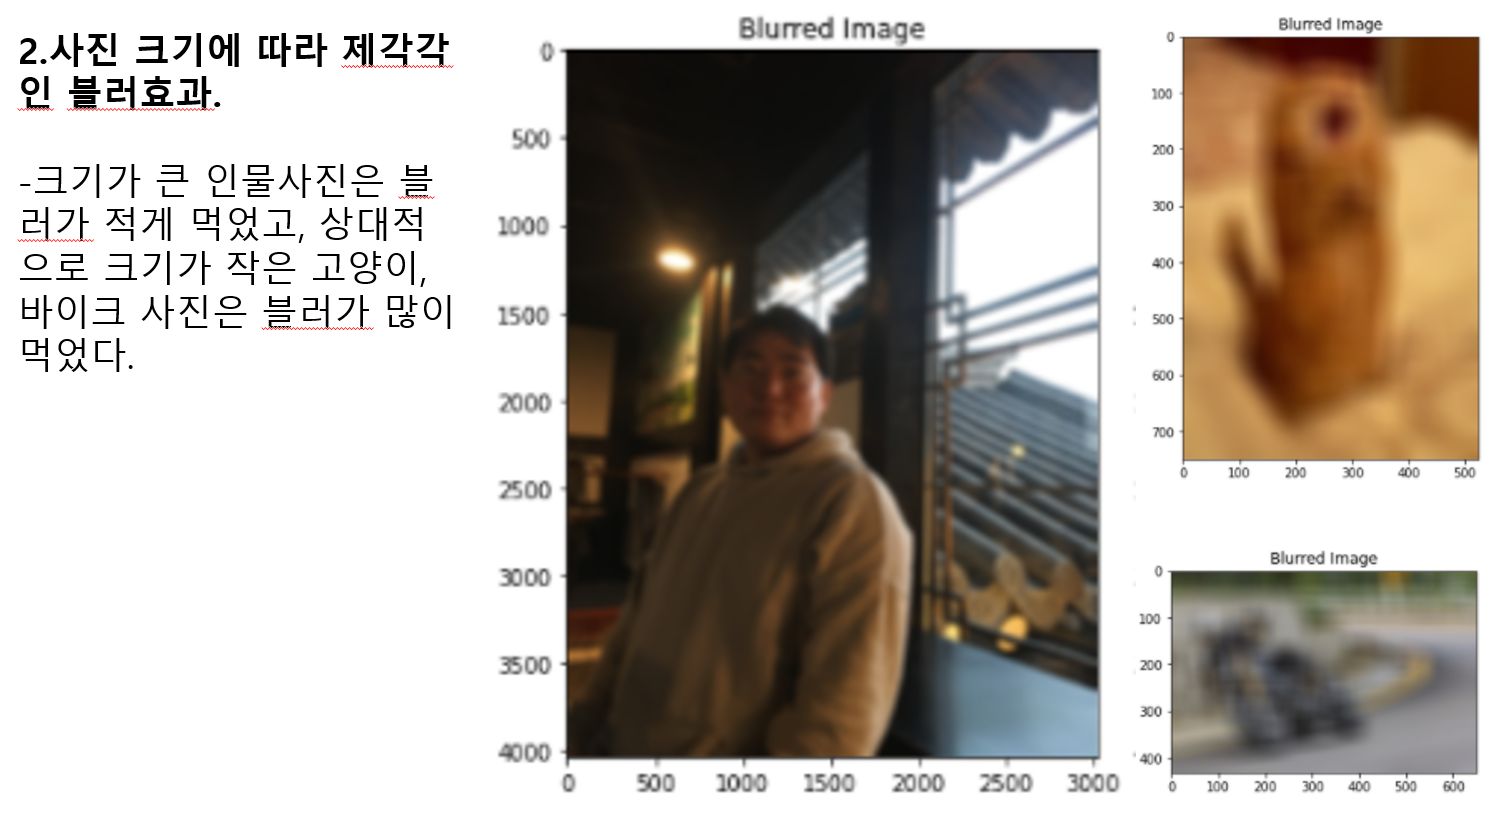

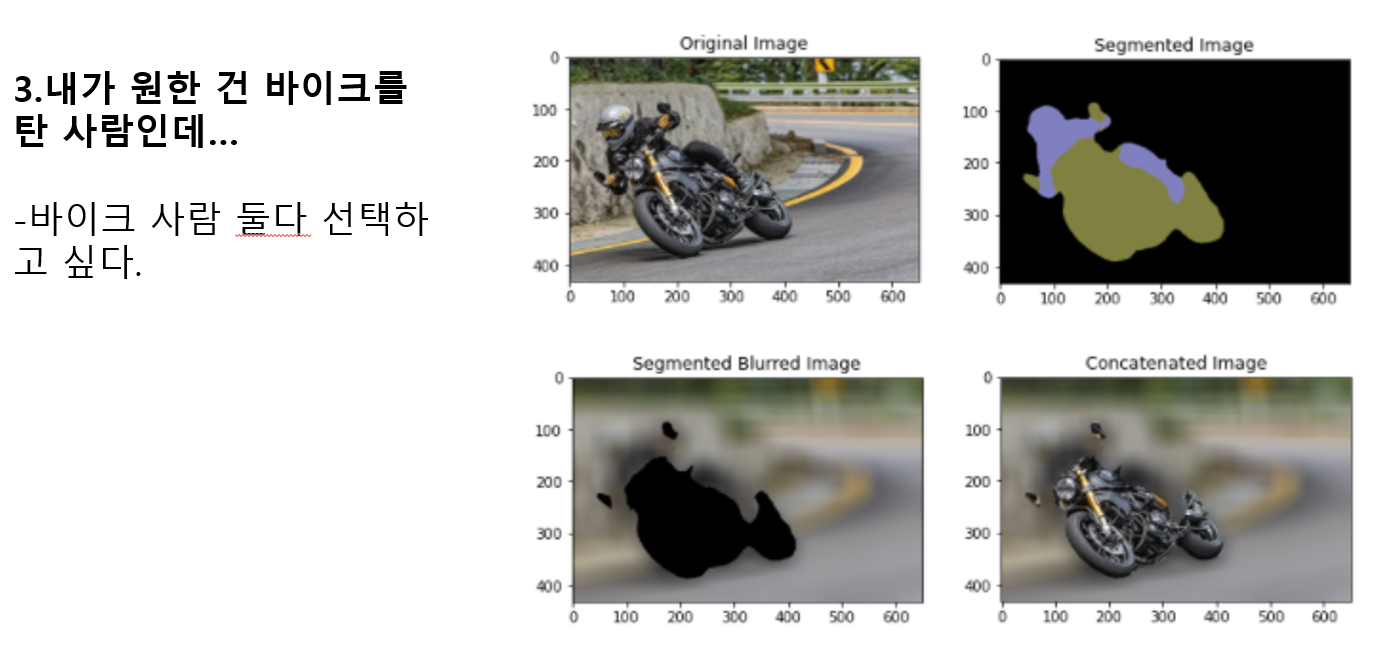

# Step 3. 해결 방법을 제안해 보기

# 1. 세그멘테이션 모델의 문제.
- 세그멘테이션 모델의 정확도가 1.00이 되지 않는 한, 앞서 발견한 고양이 꼬리가 잘리는 것과 같은 문제를 해결하기 어렵다고 판단된다.

# 2. 심도를 고려하지 않은 균일한 블러 커널 사이즈
- 아웃포커스는 심도를 얕게 하는 효과이다. 그렇기에 배경이미지의 공간상 깊이가 다양할 경우, 깊이에 따라 블러효과가 적용되는 정도가 달라야한다.
## A. struct2depth 라는 연구에 따르면, 이미지로 부터 깊이를 예측하는 비지도 학습이 있다.해당 기술을 활용한다면 다음과 같이 이미지의 깊이를 반영하여 아웃포커스 이미지를 만들어 낼수 있을 것이다.
> 1. 이미지 세그멘테이션으로 아웃포커싱할 피사체를 얻는다.
> 2. struct2depth 를 활용하여 이미지의 깊이정보를 얻는다.
> 3. 1번에서 얻은 피사체 픽셀들의 위치에 대응하는 2번에서 얻은 깊이정보에서, 평균 깊이정보를 구한다.(그리고 이것을 Focus Point로 정한다.)
> 4. 피사체를 제외한 배경에 픽셀에 대해서 Blur 를 적용한다. 이때, 각 배경 픽셀의 깊이정보와, Focus Point 와의 차이에 비례하여, Blur_Kernel_size가 적용되도록 한다. 즉, Focus Point로 부터 깊이 거리차이가 큰 픽셀은 블러커널 크기를 크게 하고, 가까운 픽셀은 작게하여, 아웃 포커스 된 이미지의 배경에서도, 깊이에 따라 블러 정도가 다르게 적용될 수 있도록 한다. 이를 통해 더 자연스러운 아웃 포커스를 구현 할 수 있을 것이다.

## B.1 피사체 크기에 비례한 블러커널크기 설정
- 혹은 피사체 이미지의 크기에 따라 블러커널크기를 비례하여 지정한다면, 간단하게 자연스러운 아웃포커스를 적용할수 있을 것이다.
- 상기 함수에서 seg_map을 받아 피사체픽셀이 True 인 구간의 사이즈를 구한다.
- 피사체 사이즈의 가로와 세로의 기하평균을 seg_size로 구한다.
- 내사진 기준 , 50의 커널사이즈가 적당했으므로 커널사이즈/seg_size의 비율로 이미지의 커널사이즈가 조절되도록한다.
- 내사진 피사체의 seg_size 는 약 2111 이고, 커널 사이즈 50이므로, 그 비율은 약 0.0236854571293226 이다.

In [76]:
import math

def get_blur_size(seg_map):
    i_list = []
    j_list = []
    for idx, i in enumerate(seg_map):
        if np.any(i):
            i_list.append(idx)
        for jdx, j in enumerate(i):
            if np.any(j):
                #break
                j_list.append(jdx)
    i_max = max(i_list)
    i_min = min(i_list)
    j_max = max(j_list)
    j_min = min(j_list)
   
    seg_size = int(math.sqrt((i_max - i_min)*(j_max -j_min))) # 세스멘트 영역의 기하평균
    kernel_size = round(seg_size*0.0236854571293226) # 내사진 seg_size 3491을 적당했던 커널크기 50에 나눈 비율
    print('세그사이즈',seg_size)
    return (kernel_size, kernel_size)

In [77]:
# 피사체 크기에 따라 블러커널크기를 정해보자.
def get_portrait_mode2(img_path):
    # 이미지 읽기
    img_orig = get_img_orig(img_path)
    
    # 모델에 이미지 입력
    output = get_segmentation(img_path, img_orig.shape)
    
    seg_map = get_colormap(output)
    
    blur_kernel_size = get_blur_size(seg_map)
    print(blur_kernel_size)
    img_show, img_mask = get_img_mask(img_orig, seg_map)
    
    img_orig_blur, img_bg_blur, img_mask_color = get_blur_img(img_orig, img_mask, blur_kernel_size = (blur_kernel_size))
    
    img_concat = get_concatenated_img(img_orig, img_bg_blur, img_mask_color)
    
    imgs = (img_orig, output, seg_map, img_show, img_orig_blur , img_bg_blur, img_concat)
    imgs_title = ('Original Image', 'Segmented Image', 'Gray_Segmented Image', 'Masked Image', 'Blurred Image',
                  'Segmented Blurred Image', 'Concatenated Image')
    img_sub_plot(imgs, imgs_title)

(4032, 3024, 3)


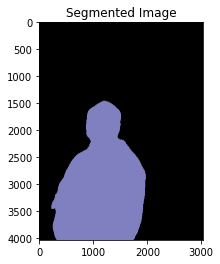

0 : background
15 : person
SELECT LABEL TO BLUR (serate with space to select multiple object, ex)"8 15" : 15
(4032, 3024)
세그사이즈 2111
(50, 50)


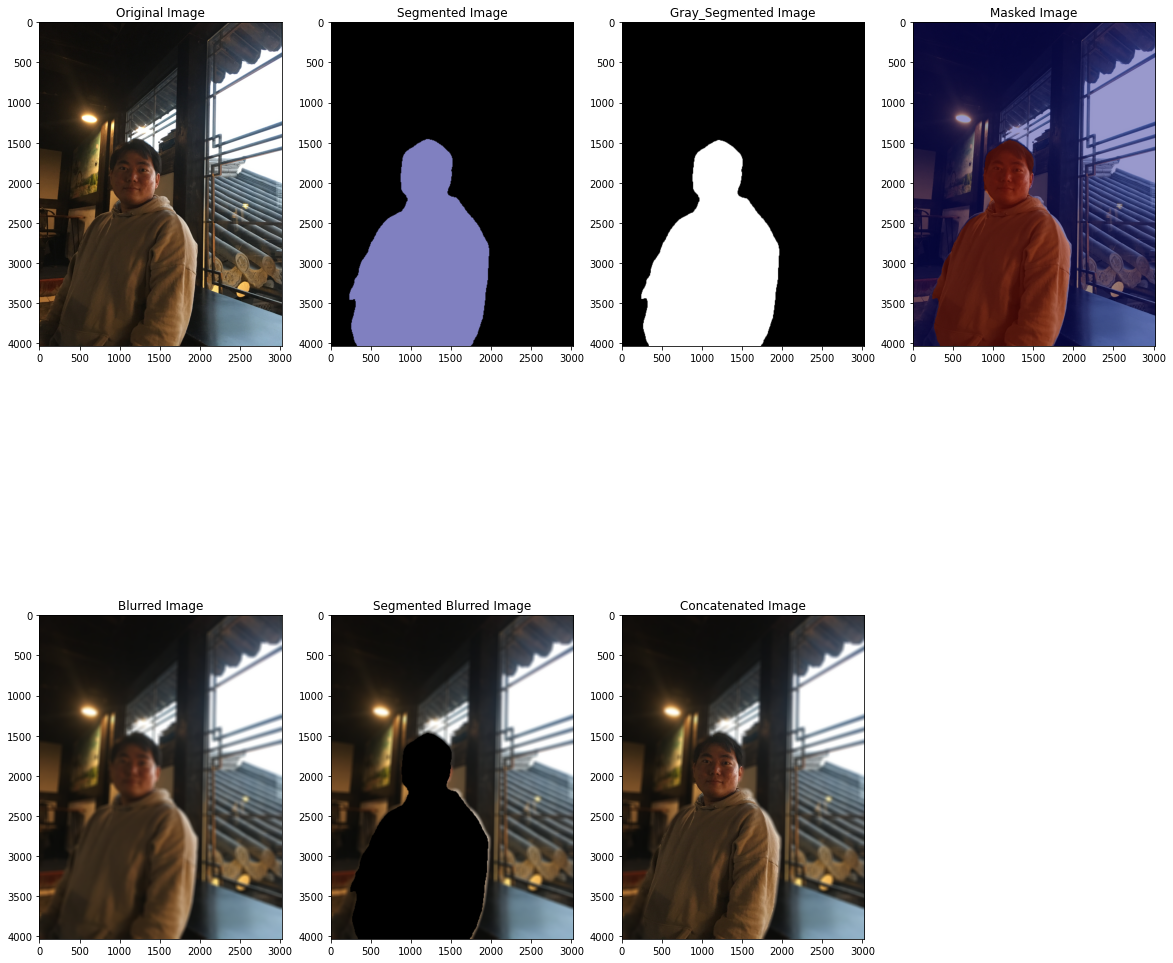

In [79]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/허남철.jpg' 
seg_map = get_portrait_mode2(img_path)

(750, 524, 3)


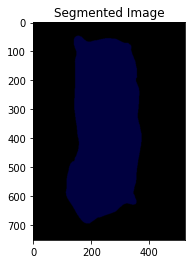

0 : background
8 : cat
SELECT LABEL TO BLUR (serate with space to select multiple object, ex)"8 15" : 8
(750, 524)
세그사이즈 406
(10, 10)


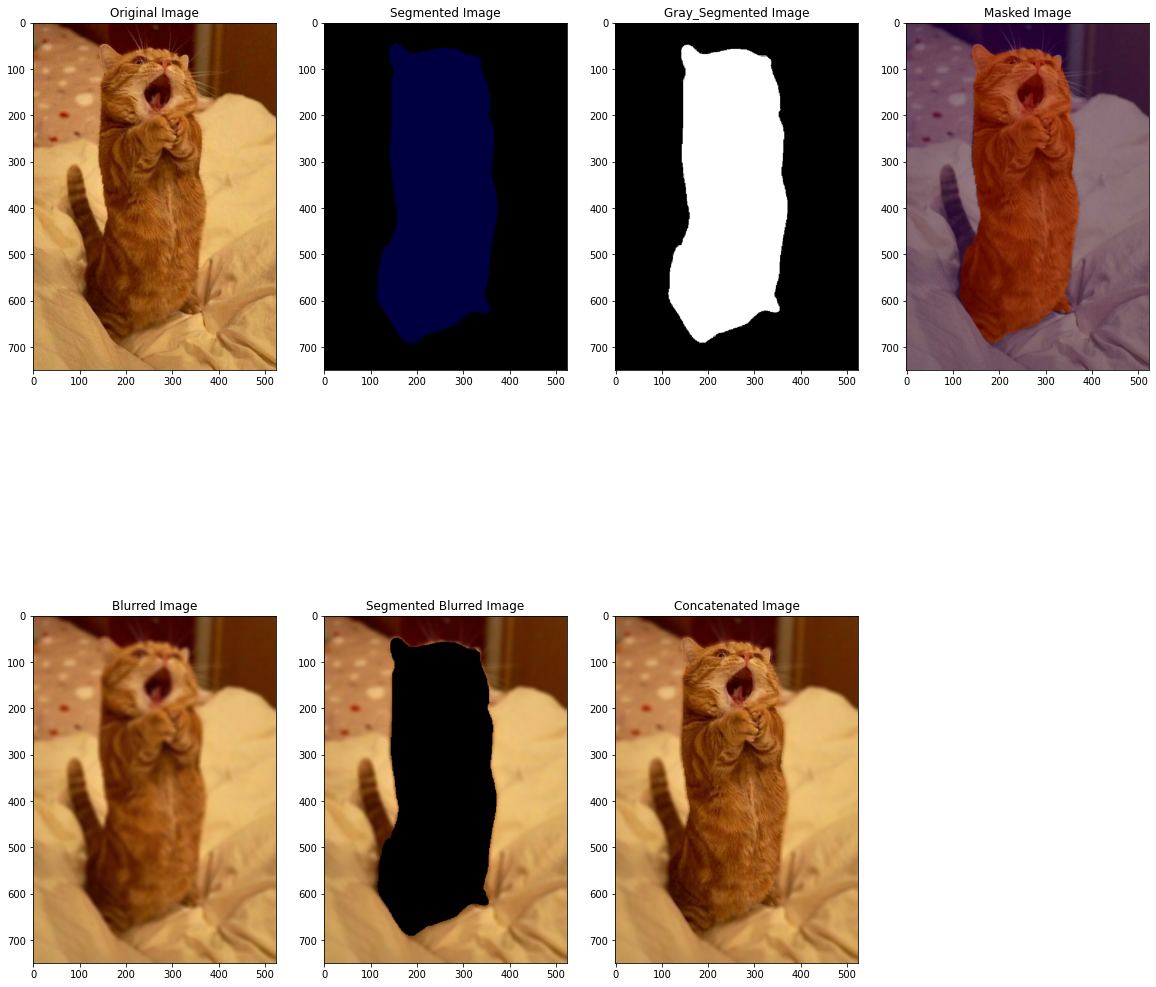

In [78]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.PNG' 
seg_map = get_portrait_mode2(img_path)

(432, 650, 3)


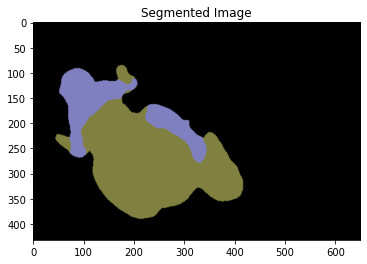

0 : background
14 : motorbike
15 : person
SELECT LABEL TO BLUR (serate with space to select multiple object, ex)"8 15" : 14 15
(432, 650)
세그사이즈 332
(8, 8)


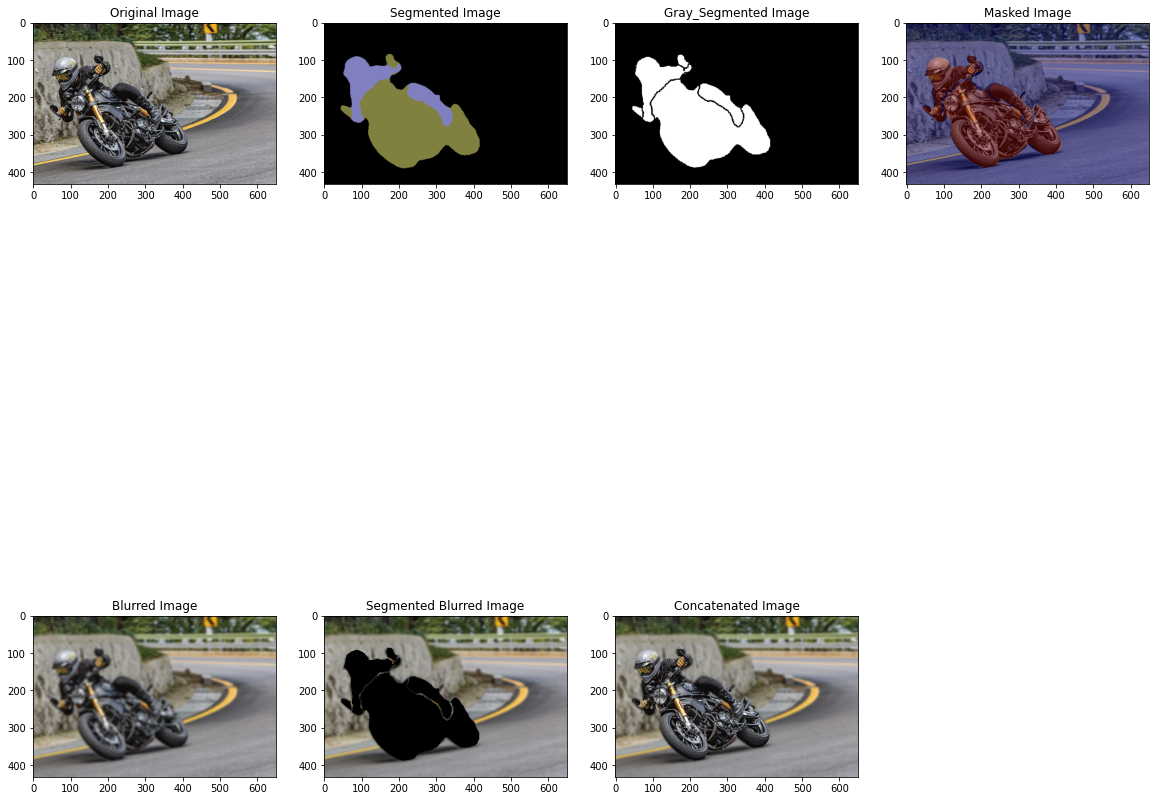

In [80]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bike.jpg' 
seg_map = get_portrait_mode2(img_path)

***
## B.2 결과 비교.
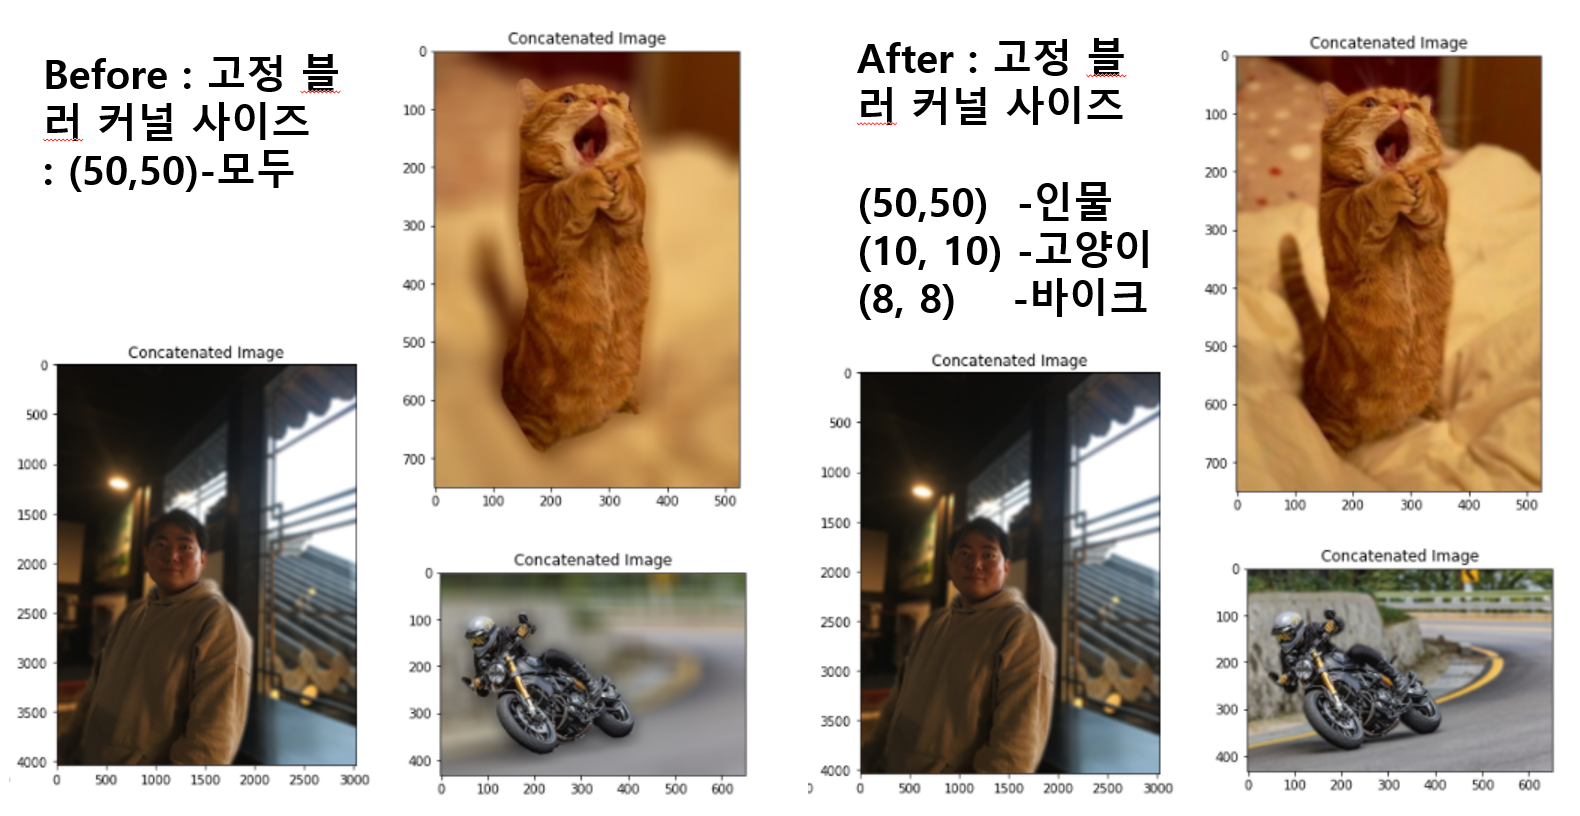

### - 피사체 크기에 따라 커널블러 사이즈를 조정되게 하였더니 더 자연스러운 블러로 아웃 포커싱 된것을 볼수 있다.

***
# 3.복수의 라벨을 묶어서 나머지 배경에 블러 적용하자
### - LMS 코드를 참고하여 상기 코드에 수정하였다.
### 1. 두개 이상의 라벨 선택을 입력받는다.
### 2. 입력받은 라벨 모두 적용되도록 수정.

(432, 650, 3)


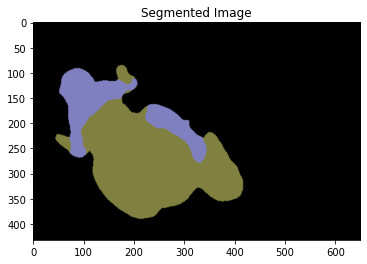

0 : background
14 : motorbike
15 : person
SELECT LABEL TO BLUR (serate with space to select multiple object, ex)"8 15" : 14 15
(432, 650, 3)
(432, 650)
(432, 650)
SegColors []
(432, 650)


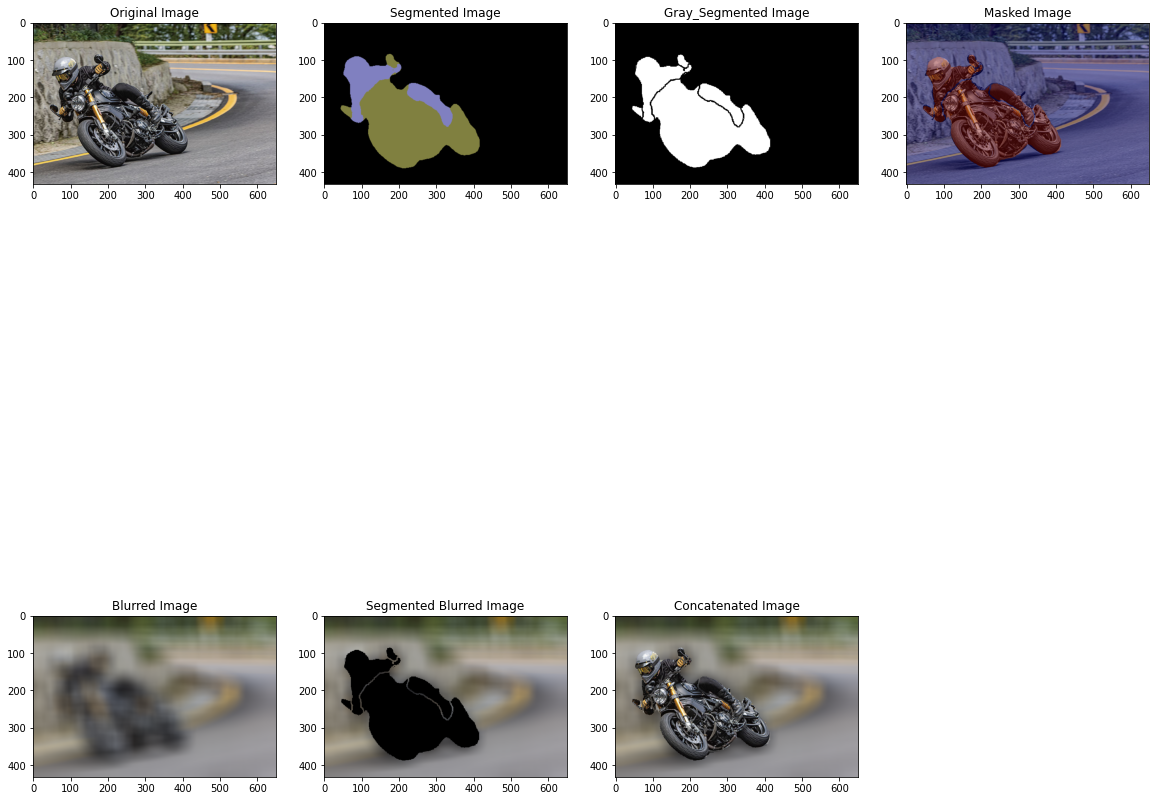

In [172]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bike.jpg' 
get_portrait_mode(img_path)

# 회고
- 어려웠던 점 : 적당한 고양이 사진을 찾다가 빠져서 시간가는 줄도 모를뻔 했다.
- 시도한 것
> 1. 2개 이상의 라벨에 대해서도 아웃포커싱이 작동할수 있도록 코드를 수정하였다.예) 바이크를 타는 사람 사진의 경우 두개의 라벨에 대해서 아웃포커싱 되어야한다.
> 2. 자연스러운 블러커널크기를 설정하기 위해, 피사체 이미지의 크기에 따라 가변적으로 블러커널크기가 적용될 수 있도록 하였다.
> 3. 크로마키에서 배경이미지의 중앙에 적용이미지가 위치하고 적용이미지크기로 잘리게 하여 배경이미지의 가로세로 비율 왜곡을 피하였다.
- 아쉬운 점 : 크로마키에서 원본이미지 가 더 큰경우, 배경이미지를 자르거나 비율의 왜곡 없이 처리하는 부분을 해결하지 못해서 아쉽다.
- 자기 다짐 : 화이팅.